In [1]:
import sys
sys.path = sys.path+['.\\source']

from helper_functions import WORLD_DISTRIBUTION

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
datapoints = [
    [0,0],
    [2,1],
    [4,1.4],
    [14,0.1],
    [23,2],
    [26,1],
    [30,0],
]

wd = WORLD_DISTRIBUTION(datapoints=datapoints)

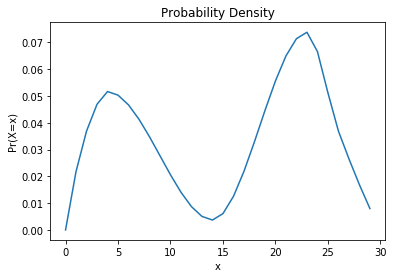

In [3]:
wd.plot_distribution()

# Network Eigenstate

What's the final state a graph network $\mathcal{G}$ will settle in if provided with input $\vec{s}_0$ and an update euqation, and then left alone?

In [93]:
# Imports

import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,sys,math,itertools

import torch
import pandas as pd

from scipy import linalg as la

In [154]:
class GRAPH():
    def __init__(self,N,f=lambda x: x,MAXSTATESHIST=10):
        # Parameters
        self.N = N
        # Weight matrix, bias and non-linearity
        self.W = rnd.randn(N,N)
        self.b = rnd.randn(N)
        self.f = f
        # Init random state
        self.s = rnd.randn(N)/self.N
        # State history
        self.MAXSTATESHIST = MAXSTATESHIST
        self.S = []
        self.S.append(self.s)
        # Return
        return
    def set_state(self,s):
        self.s = s
        self.__update_states_hist(s)
        return
    def update(self,steps=1,norm=True):
        for step in range(steps):
            self.s = self.f(np.dot(self.W,self.s)) + self.b
            self.s = self.s/(self.N if norm else 1)
            self.__update_states_hist(self.s)
        return
    def __update_states_hist(self,x):
        self.S.append(x)
        if len(self.S)>self.MAXSTATESHIST: self.S = self.S[-self.MAXSTATESHIST:]
        return

In [187]:
# Network setup

G = GRAPH(N=10)

In [188]:
s0 = G.s
G.update(steps=10,norm=False)

For the update function $f(\vec{x})=\vec{x}$, the update equation for $\mathcal{G}$ after $N$ steps becomes
$$
    \vec{s}_{N} = \mathbf{W}^N\vec{s}_0 + \sum_{k=0}^N\mathbf{W}^k\vec{b}
$$
Eigendecomposition for $\mathbf{W}$ yields
$$
    \mathbf{W} = \mathbf{E}\mathbf{\Lambda}\mathbf{E}^{-1}\Rightarrow\mathbf{W}^N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}
$$
Therefore $\vec{s}_N$ can be written as
$$
    \vec{s}_N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + \sum_{k=0}^{N-1}\mathbf{E}\mathbf{\Lambda}^k\mathbf{E}^{-1}\vec{b}\Leftrightarrow\vec{s}_N = \mathbf{E}\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + \sum_{k=0}^{N-1}\mathbf{E}\mathbf{\Lambda}^k\mathbf{E}^{-1}\vec{b}
$$

In [189]:
# Calculate analytically the state after K steps

ev,EV = la.eig(G.W)

K = 10

T = np.dot(np.dot(EV,np.diag(ev**K)),np.linalg.inv(EV))
sN = np.dot(T,s0)

EE = np.diag(ev**0)
for k in range(1,K):
    EE += np.diag(ev**k)
sN += np.dot(np.dot(np.dot(EV,EE),np.linalg.inv(EV)),G.b) 

In [190]:
sN

array([-1758.42340908-1.96952485e-12j,   140.96167598+2.35089281e-12j,
       -1263.02821239+1.21966644e-12j,  2400.49690565-8.86734026e-12j,
       -4204.03379939-6.50664127e-12j, -9847.64977287+1.83054432e-11j,
       -5833.19424694+4.36501490e-12j,  2274.03393481+2.58247613e-11j,
        3505.59960904+5.36853746e-12j, 14226.24092982-9.41246627e-12j])

In [191]:
G.s

array([-1758.42340908,   140.96167598, -1263.02821239,  2400.49690565,
       -4204.0337994 , -9847.64977287, -5833.19424694,  2274.03393481,
        3505.59960904, 14226.24092982])

This seems to work, so we can assume that the following simplification holds:
$$
    \vec{s}_N = \mathbf{E}(\mathbf{\Lambda}^N\mathbf{E}^{-1}\vec{s}_0 + (\sum_{k=0}^{N-1}\mathbf{\Lambda}^k)\mathbf{E}^{-1}\vec{b})
$$